<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/MachineLearning/How_to_predict_cancer_survival_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Predict Cancer Survival Time with TensorFlow

Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** How to predict cancer survival time with TensorFlow
- **Author:** John Phan
- **Created:** 2022-01-22
- **Purpose:** Demonstrate use of regression in TensorFlow to predict cancer patient survival time 
- **URL:** https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_predict_cancer_survival_time_with_TensorFlow.ipynb

This notebook demonstrates how to predict the survival time in months for cancer patients using  regression in TensorFlow with a deep neural network (DNN). Refer to this TensorFlow example for more information: https://www.tensorflow.org/tutorials/keras/regression

This example uses a kidney cancer study that identified a 15 gene predictive signature. The study is available here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113007/ 

The total BigQuery cost for running this notebook is <$0.10. No additional costs are incurred if using Colab. However, if running this code on a VM with GPUs, additional hourly VM costs may be incurred. 

## Import Dependencies

In [89]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Authenticate

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). Alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

In [90]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

## Parameters

Customize the following parameters based on your notebook, execution environment, or project. BigQuery ML must create and store classification models, so be sure that you have write access to the locations stored in the "bq_dataset" and "bq_project" variables.

In [91]:
# set the google project that will be billed for this notebook's computations
google_project = 'google-project' ## CHANGE ME

# in this example, we'll be using the Ovarian cancer TCGA dataset
cancer_type = 'TCGA-KIRC'

# 14 genes used for prediction model, taken from Li et al.
# Note: one gene (ZIC2) was omitted from the original set of 15 genes due to 
# missing values in some TCGA samples. 
genes = [
  'CCDC137', 'KL', 'FBXO3', 'CDC7', 'IL20RB', 'CDCA3', 'ANAPC5',
  'OTOF', 'POFUT2', 'ATP13A1', 'MC1R', 'BRD9', 'ARFGAP1', 'COL7A1'
]

# clinical data table
clinical_table = 'isb-cgc-bq.TCGA_versioned.clinical_gdc_r29'

# RNA seq data table
rnaseq_table = 'isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28'


## BigQuery Client

Create the BigQuery client.

In [92]:
# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

## Extract Gene Expression Data from BigQuery

Pull RNA-seq gene expression data from the TCGA RNA-seq BigQuery table, join it with clinical labels, and pivot the table so that it can be used with TensorFlow. In this example, we will label each sample with the patient's survival time. This prepares the data for regression. 

Prediction modeling with RNA-seq data typically requires a feature selection step to reduce the dimensionality of the data before training a regression model. However, to simplify this example, we will use a pre-identified set of 14 genes from the study by Li et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113007/). Note that one gene was omitted due to missing values.

This query also randomly splits the dataset into "training" and "testing" sets with roughly equal sample sizes using the "FARM_FINGERPRINT" hash function in BigQuery. "FARM_FINGERPRINT" generates an integer from the input string. More information can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/hash_functions).

In [93]:
# construct and display the query
data_query = ("""
  SELECT * FROM (
    SELECT
      labels.submitter_id AS sample,
      labels.data_partition AS data_partition,
      MAX(labels.survival) AS survival,
      ge.gene_name AS gene_name,
      -- Multiple samples may exist per case, take the max value
      MAX(LOG(ge.HTSeq__FPKM_UQ+1)) AS gene_expression
    FROM `{rnaseq_table}` AS ge
    INNER JOIN (
      SELECT
        *
      FROM (
        SELECT
          submitter_id,
          demo__days_to_death AS survival,
          CASE 
            WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) < 5 THEN 'training'
            WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) >= 5 THEN 'testing'
          END AS data_partition
          FROM `{clinical_table}`
          WHERE
            proj__project_id = '{cancer_type}'
            AND demo__days_to_death IS NOT NULL
          ORDER BY demo__days_to_death DESC
      )
    ) labels
    ON labels.submitter_id = ge.case_barcode
    WHERE gene_name IN ({genes})
    GROUP BY sample, data_partition, gene_name
  )
  PIVOT (
    MAX(gene_expression) FOR gene_name IN ({genes})
  )
""").format(
  rnaseq_table=rnaseq_table,
  clinical_table=clinical_table,
  cancer_type=cancer_type,
  genes=''.join(["'","','".join(genes),"'"])
)

print(data_query)


  SELECT * FROM (
    SELECT
      labels.submitter_id AS sample,
      labels.data_partition AS data_partition,
      MAX(labels.survival) AS survival,
      ge.gene_name AS gene_name,
      -- Multiple samples may exist per case, take the max value
      MAX(LOG(ge.HTSeq__FPKM_UQ+1)) AS gene_expression
    FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28` AS ge
    INNER JOIN (
      SELECT
        *
      FROM (
        SELECT
          submitter_id,
          demo__days_to_death AS survival,
          CASE 
            WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) < 5 THEN 'training'
            WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) >= 5 THEN 'testing'
          END AS data_partition
          FROM `isb-cgc-bq.TCGA_versioned.clinical_gdc_r29`
          WHERE
            proj__project_id = 'TCGA-KIRC'
            AND demo__days_to_death IS NOT NULL
          ORDER BY demo__days_to_death DESC
      )
    ) labels
    ON labels.submitter_id = ge.case_barcode
    WHERE gene_n

In [94]:
# this query processes 20 GB and costs approximately $0.10
data = client.query(data_query).result().to_dataframe()

Let's take a look at this subset table. The data has been pivoted such that each of the 14 genes is available as a column that can be "SELECTED" in a query. In addition, the "survival" and "data_partition" columns simplify data handling for model training and evaluation.

In [95]:
data

,sample,data_partition,survival,CCDC137,KL,FBXO3,CDC7,IL20RB,CDCA3,ANAPC5,OTOF,POFUT2,ATP13A1,MC1R,BRD9,ARFGAP1,COL7A1
0,TCGA-AK-3455,testing,683,11.821745,13.326113,12.403776,10.051252,9.664453,8.837780,12.342919,7.430097,11.807020,11.962827,9.586711,11.047651,12.158947,7.850365
1,TCGA-CJ-5677,testing,782,12.245250,14.661966,11.863863,10.401224,14.178713,10.559196,12.131710,6.828847,12.402746,12.648536,9.065563,11.283452,12.619064,9.696658
2,TCGA-DV-A4VX,testing,1626,12.368437,11.986560,11.983827,10.512078,13.427324,11.058579,12.688938,6.816680,11.550429,12.268609,9.578228,11.749996,12.733932,8.760610
3,TCGA-B0-5092,testing,459,12.291751,12.360812,11.323301,10.510342,12.524597,10.636912,12.541131,7.987389,12.396105,12.569231,10.690693,11.435689,12.858521,11.239858
4,TCGA-BP-4798,training,334,11.894763,12.266688,10.957281,10.743430,13.067092,10.055239,12.410996,8.925046,12.185975,12.541821,9.386611,11.431957,12.596742,8.229138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,TCGA-BP-4787,testing,480,11.985341,12.365776,11.278517,10.058439,14.617341,9.623050,12.372742,5.190399,11.887072,12.536167,10.177528,11.442994,12.803234,8.709844
167,TCGA-BP-4981,training,1097,12.528847,12.059698,11.629544,10.011731,10.198068,8.942412,12.227246,6.952234,12.444176,12.536982,11.617060,11.507760,12.729785,9.102123
168,TCGA-B0-4700,testing,1980,12.395055,14.261705,11.795183,10.962550,13.231652,10.748777,12.358914,8.220847,12.130186,12.272660,9.830711,11.464391,13.113979,10.010658
169,TCGA-B0-4821,testing,1230,12.597532,10.115534,11.314814,11.334176,13.522059,11.837168,12.514082,7.623032,12.827489,12.772952,11.058194,12.363918,14.283928,12.686951


## Split the Data into Training and Testing Sets

Partition the data in order to train and test the regression model. 

In [96]:
train_x = data[data['data_partition']=='training'][genes]
train_y = data[data['data_partition']=='training'][['survival']]
test_x = data[data['data_partition']=='testing'][genes]
test_y = data[data['data_partition']=='testing'][['survival']]

## Normalize the Data

The data must first be normalized such that it is mean centered and scaled to unit variance. 

In [97]:
# normalize the data using a TensorFlow Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_x))

## Build a Regression Model using a Deep Neural Network

We use TensorFlow to build a three-layer deep neural network (DNN). 

In [98]:
dnn_model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

dnn_model.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001)
)

In [99]:
# display a summary of the model
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 14)               29        
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                960       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,214
Trainable params: 5,185
Non-trainable params: 29
_________________________________________________________________


## Train the Regression Model

Using the "fit" TensorFlow method, we train the regression model over 1000 epochs and plot the loss, or error, of the model as a function of the epochs. 

In [100]:
# train the model and note how long it takes
%%time
history = dnn_model.fit(train_x, train_y, epochs=1000, verbose=0, validation_split=0.2)

CPU times: user 28.6 s, sys: 1.37 s, total: 30 s
Wall time: 27.9 s


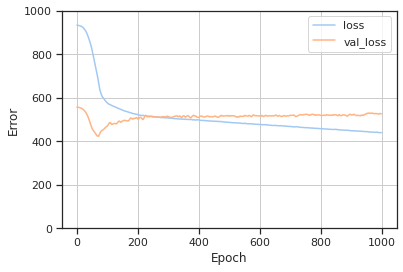

In [101]:
# plot loss of the model as it is trained
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 1000])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

## Predict Survival Time for Both Training and Testing Sets

With the TensorFlow "predict" method, we can predict the survival time for each training and testing sample using the trained model. 

In [102]:
train_predict = dnn_model.predict(train_x)
test_predict = dnn_model.predict(test_x)

## Visualize the Regression Model

Combine results into a single data frame in order to visualize the model.

In [103]:
# create combined and labeled dataframes for plotting
train_plot = pd.DataFrame(np.concatenate((np.reshape(train_y.to_numpy(), (len(train_predict),1)), train_predict), axis=1))
train_plot.rename(columns={0: 'survival', 1:'predicted_survival'}, inplace=True)
train_plot['group'] = 'training'

test_plot = pd.DataFrame(np.concatenate((np.reshape(test_y.to_numpy(), (len(test_predict),1)), test_predict), axis=1))
test_plot.rename(columns={0: 'survival', 1:'predicted_survival'}, inplace=True)
test_plot['group'] = 'testing'

combined = pd.concat([train_plot, test_plot])

# display the combined data frame
combined

,survival,predicted_survival,group
0,334.0,413.154358,training
1,245.0,316.698364,training
2,202.0,211.786469,training
3,222.0,335.101532,training
4,1912.0,781.327087,training
...,...,...,...
82,1075.0,950.602295,testing
83,480.0,1402.730591,testing
84,1980.0,230.009171,testing
85,1230.0,1369.197388,testing


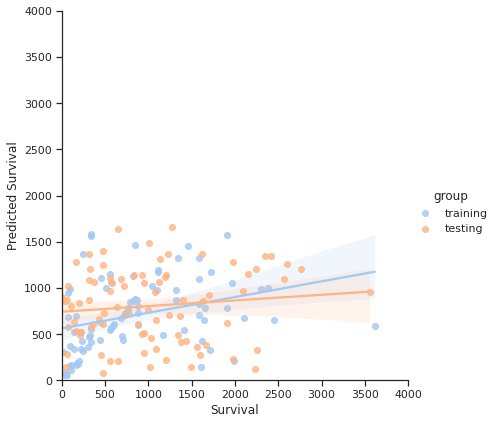

In [104]:
# use seaborn to generate a scatter plot of regression results
sns.set_theme(style='ticks', palette='pastel')
ax = sns.lmplot(data=combined, hue='group', x='survival', y='predicted_survival', height=6, aspect=1)
ax.set(xlim=(0,4000), ylim=(0,4000),xlabel='Survival',ylabel='Predicted Survival')

# Conclusion

Although there is somewhat of a positive correlation between predicted survival time and actual survival time, the relationship is weak and the model's error remains high even after training for hundreds of epochs. Note that even for the training samples (orange points) the model does not predict survival well, suggesting that it is underfitting. 

This example used a pre-selected set of 14 genes from a previous study. However, performing additional feature selection or increasing the feature size (e.g., increase to 30+ features) may improve model performance. DNN parameters (i.e., number of layers, number of neurons for each layer, etc.) may also be tuned to improve model performance. 

Despite the poor prediction performance, this notebook serves to demonstrate how to construct a regression model using TensorFlow. 